In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import numpy as np
import torch
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from torch import nn
from torch import optim
import torch.nn.functional as F
from collections import OrderedDict

In [6]:
# Define a transform to normalize the data
transform = transforms.Compose([transforms.ToTensor(),
                              transforms.Normalize((0.5,), (0.5,)),
                             ])
# Download and load the training data
trainset = datasets.FashionMNIST('F_MNIST_data/', download=True, train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

# Download and load the test data
testset = datasets.FashionMNIST('F_MNIST_data/', download=True, train=False, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=True)

In [7]:
def imshow(image, ax=None, title=None, normalize=True):
    """Imshow for Tensor."""
    if ax is None:
        fig, ax = plt.subplots()
    image = image.numpy().transpose((1, 2, 0))

    if normalize:
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        image = std * image + mean
        image = np.clip(image, 0, 1)

    ax.imshow(image)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.tick_params(axis='both', length=0)
    ax.set_xticklabels('')
    ax.set_yticklabels('')

    return ax

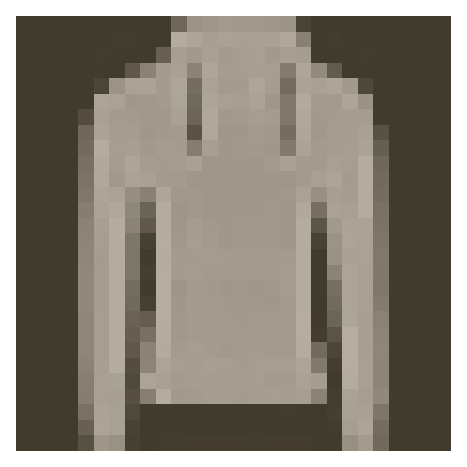

In [8]:
def view_classify(img, ps, version="Fashion"):
    ''' Function for viewing an image and it's predicted classes.
    '''
    ps = ps.data.numpy().squeeze()

    fig, (ax1, ax2) = plt.subplots(figsize=(6,9), ncols=2)
    ax1.imshow(img.resize_(1, 28, 28).numpy().squeeze())
    ax1.axis('off')
    ax2.barh(np.arange(10), ps)
    ax2.set_aspect(0.1)
    ax2.set_yticks(np.arange(10))
    if version == "MNIST":
        ax2.set_yticklabels(np.arange(10))
    elif version == "Fashion":
        ax2.set_yticklabels(['T-shirt/top',
                            'Trouser',
                            'Pullover',
                            'Dress',
                            'Coat',
                            'Sandal',
                            'Shirt',
                            'Sneaker',
                            'Bag',
                            'Ankle Boot'], size='small');
    ax2.set_title('Class Probability')
    ax2.set_xlim(0, 1.1)

#Display the images from the traning data
image, label = next(iter(trainloader))
imshow(image[1,:]);

In [10]:
class Network(nn.Module):
    def __init__(self):
        super().__init__()
        # Defining the layers, 128, 64, 10 units each
        self.fc1 = nn.Linear(784, 128)
        self.fc2 = nn.Linear(128, 64)
        # Output layer, 10 units - one for each digit
        self.fc3 = nn.Linear(64, 10)
        
    def forward(self, x):
        ''' Forward pass through the network, returns the output logits '''
        
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.fc3(x)
        x = F.softmax(x, dim=1)
        
        return x

In [11]:
model = Network()

In [13]:
# Grab traning data
dataiter = iter(trainloader)
images, labels = dataiter.next()

In [14]:
# Resize images into a 1D vector, new shape is (batch size, color channels, image pixels) 
images.resize_(64, 1, 784)
# or images.resize_(images.shape[0], 1, 784) to not automatically get batch size

tensor([[[-1., -1., -1.,  ..., -1., -1., -1.]],

        [[-1., -1., -1.,  ..., -1., -1., -1.]],

        [[-1., -1., -1.,  ..., -1., -1., -1.]],

        ...,

        [[-1., -1., -1.,  ..., -1., -1., -1.]],

        [[-1., -1., -1.,  ..., -1., -1., -1.]],

        [[-1., -1., -1.,  ..., -1., -1., -1.]]])

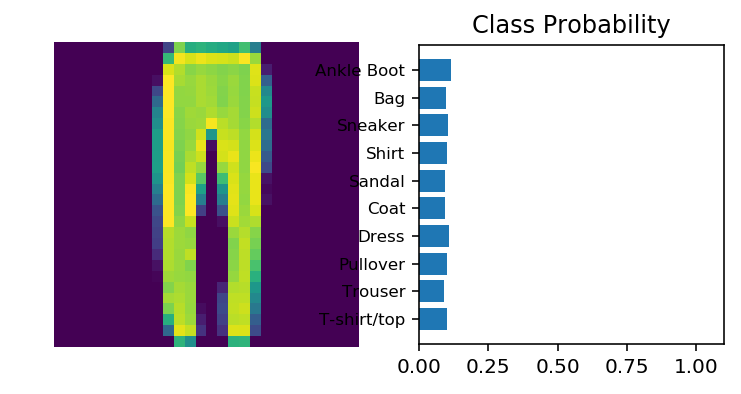

In [15]:
# Forward pass through the network
img_idx = 0
ps = model.forward(images[img_idx,:])

img = images[img_idx]
view_classify(img.view(1, 28, 28), ps)

In [16]:
# Hyperparameters for our network
input_size = 784
hidden_sizes = [200, 100]
output_size = 10

In [17]:
model = nn.Sequential(OrderedDict([
                      ('fc1', nn.Linear(input_size, hidden_sizes[0])),
                      ('relu1', nn.ReLU()),
                      ('fc2', nn.Linear(hidden_sizes[0], hidden_sizes[1])),
                      ('relu2', nn.ReLU()),
                      ('output', nn.Linear(hidden_sizes[1], output_size)),
                      ('relu3', nn.ReLU())]))

In [18]:
# Traning Our Model
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.1)

images, labels = next(iter(trainloader))
images.resize_(64, 784)

# Clear the gradients, do this because gradients are accumulated
optimizer.zero_grad()

# Forward pass, then backward pass, then update weights
output = model.forward(images)
loss = criterion(output, labels)
loss.backward()
#print('Gradient -', model.fc1.weight.grad)
optimizer.step()

epochs = 5
print_every = 100
steps = 0
for e in range(epochs):
    running_loss = 0
    for images, labels in iter(trainloader):
        steps += 1
        # Flatten MNIST images into a 784 long vector
        images.resize_(images.size()[0], 784)
        
        optimizer.zero_grad()
        
        # Forward and backward passes
        output = model.forward(images)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
        if steps % print_every == 0:
            print("Epoch: {}/{}... ".format(e+1, epochs),
                  "Loss: {:.4f}".format(running_loss/print_every))
            
            running_loss = 0

Epoch: 1/5...  Loss: 1.4018
Epoch: 1/5...  Loss: 0.8601
Epoch: 1/5...  Loss: 0.6082
Epoch: 1/5...  Loss: 0.5486
Epoch: 1/5...  Loss: 0.5145
Epoch: 1/5...  Loss: 0.4714
Epoch: 1/5...  Loss: 0.4889
Epoch: 1/5...  Loss: 0.4738
Epoch: 1/5...  Loss: 0.4616
Epoch: 2/5...  Loss: 0.2809
Epoch: 2/5...  Loss: 0.4107
Epoch: 2/5...  Loss: 0.4203
Epoch: 2/5...  Loss: 0.4078
Epoch: 2/5...  Loss: 0.4176
Epoch: 2/5...  Loss: 0.3986
Epoch: 2/5...  Loss: 0.3969
Epoch: 2/5...  Loss: 0.3922
Epoch: 2/5...  Loss: 0.3742
Epoch: 3/5...  Loss: 0.0864
Epoch: 3/5...  Loss: 0.3692
Epoch: 3/5...  Loss: 0.3690
Epoch: 3/5...  Loss: 0.3586
Epoch: 3/5...  Loss: 0.3360
Epoch: 3/5...  Loss: 0.3579
Epoch: 3/5...  Loss: 0.3744
Epoch: 3/5...  Loss: 0.3534
Epoch: 3/5...  Loss: 0.3589
Epoch: 3/5...  Loss: 0.3559
Epoch: 4/5...  Loss: 0.2921
Epoch: 4/5...  Loss: 0.3203
Epoch: 4/5...  Loss: 0.3396
Epoch: 4/5...  Loss: 0.3442
Epoch: 4/5...  Loss: 0.3261
Epoch: 4/5...  Loss: 0.3320
Epoch: 4/5...  Loss: 0.3295
Epoch: 4/5...  Loss:

In [19]:
# Now lets test our with trained data
images, labels = next(iter(trainloader))

In [20]:
img = images[1].view(1, 784)
# Turn off gradients to speed up this part
with torch.no_grad():
    logits = model.forward(img)

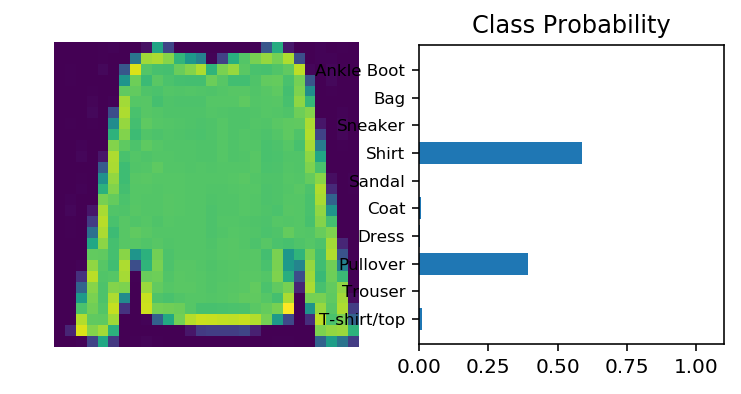

In [21]:
# Output of the network are logits, need to take softmax for probabilities
ps = F.softmax(logits, dim=1)
view_classify(img.view(1, 28, 28), ps,version='Fashion')

In [23]:
# Now lets test our with test data
images, labels = next(iter(testloader))

In [24]:
img = images[1].view(1, 784)
# Turn off gradients to speed up this part
with torch.no_grad():
    logits = model.forward(img)

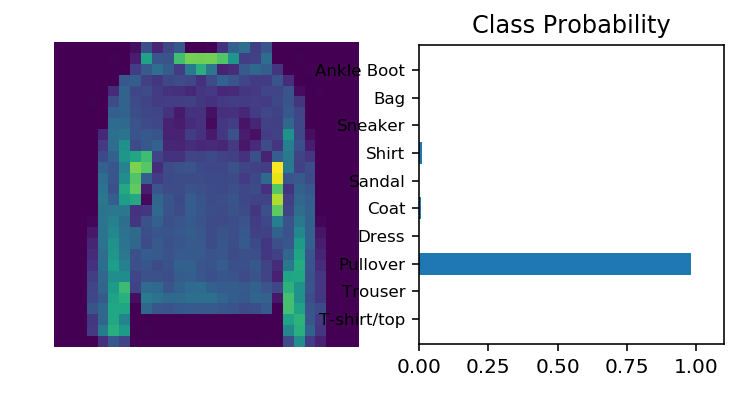

In [32]:
# Output of the network are logits, need to take softmax for probabilities
ps = F.softmax(logits, dim=1)
view_classify(img.view(1, 28, 28), ps,version='Fashion')